<a href="https://colab.research.google.com/github/AnonymousStudent22/amls2_assessment/blob/main/task_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import gensim
from textblob import TextBlob
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import tensorflow #tensorflow 2.8.0 (with Python 3.7.13)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras import metrics


from wordcloud import WordCloud
import seaborn as sns
import pprint
import matplotlib.pyplot as plt; plt.rcdefaults()


In [2]:

dataset = pd.read_csv('Datasets/SemEval2017-task4-dev.subtask-BD.english.INPUT.txt', 
                       sep='\t',header=None )
dataset.columns = ['id','topic','sentiment','tweet','unknown']
dataset = dataset.drop(['unknown'], axis=1)


dataset = dataset.drop(['id'], axis=1) # dropped id 

print("First 5 rows of dataset")
print(dataset.head(5))

print(len(dataset))


First 5 rows of dataset
         topic sentiment                                              tweet
0  amy schumer  negative  @MargaretsBelly Amy Schumer is the stereotypic...
1  amy schumer  negative  @dani_pitter I mean I get the hype around JLaw...
2  amy schumer  negative  Amy Schumer at the #GQmenoftheyear2015 party i...
3  amy schumer  negative  Amy Schumer is on Sky Atlantic doing one of th...
4  amy schumer  negative  Amy Schumer may have brought us Trainwreck, bu...
10551


Text(0.5, 1.0, 'Distribution of Sentiments')

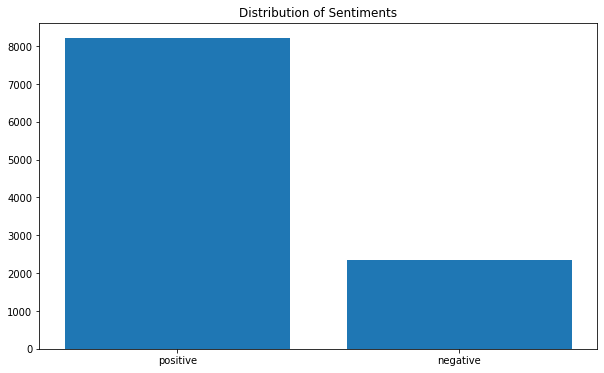

In [3]:
distribution = dataset.sentiment.value_counts() # value_counts() is a pandas function
plt.figure(figsize=(10,6))
plt.bar(distribution.index, distribution.values)
plt.title('Distribution of Sentiments')


In [4]:
# Convert to lowercase, remove punctuation, noise, such as non-alphanumeric characters, 
# urls, and double white spaces. Remove stopwords

# Downloads needed when running script on browser
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet')

def preprocess(tweet): 
    
    tweet = re.sub(r"[Ww]on't","willn't", str(tweet))# 1st step to expand "won't"
    tweet = re.sub(r"n't",' not', str(tweet)) # expand negative contractions
    tweet = re.sub(r"'ve",' have', str(tweet)) # expand "have" contractions
    tweet = re.sub(r"'s",'s' , str(tweet)) # remove apotrophe in possessives, but keep 's'
    tweet = re.sub(r"(@\S+|#\S+)",' ',str(tweet)) #remove hashtags and users: @ and #
    tweet = re.sub(r"\s\s+",' ',str(tweet)) # replace more than two spaces with one
    tweet = re.sub(r"([^a-zA-z0-9]+|https?:\S+)",' ',str(tweet).lower()).strip() #remove urls
    
    sent = TextBlob(tweet) # lemmatize text
    tag_dict = {"JJ": 'a', 
                "NN": 'n', 
                "V":  'v', 
                "R":  'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'a')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    tweet =  " ".join(lemmatized_list)
    tweet = remove_stopwords(tweet) # remove stopwords (to be done after lemmatizing)


    
    return tweet

# Use lambda to run preprocess function on each row of the dataset tweets
dataset.tweet = dataset.tweet.apply(lambda x: preprocess(x))




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
print('Tweets after preprocessing')
print(dataset['tweet'].head(5))

Tweets after preprocessing
0    amy schumer stereotypical 1st world laci green...
1    mean hype jlaw like hype understand amy schume...
2                  amy schumer party dress pretty hate
3    amy schumer sky atlantic bad stand sets sit 30...
4           amy schumer bring trainwreck word redefine
Name: tweet, dtype: object


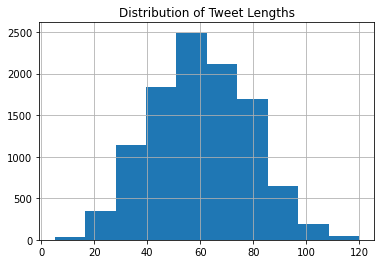

count    10551.000000
mean        59.884940
std         18.461556
min          5.000000
25%         47.000000
50%         60.000000
75%         73.000000
max        120.000000
dtype: float64

In [6]:
tweet_lengths = []
for index, row in dataset.iterrows():
    tweet_lengths.append(len(row['tweet']))
pd.Series(tweet_lengths).hist()
plt.title('Distribution of Tweet Lengths')
plt.show()
pd.Series(tweet_lengths).describe()



100
{'ant-man', 'jason aldean', 'dana white', 'zac brown band', 'thor', 'sam smith', 'bee gees', 'saudi arabia', 'dunkin', 'red sox', 'rahul gandhi', 'boko haram', 'seth rollins', 'yakub', 'rousey', 'calibraska', 'national ice cream day', 'yoga', 'prince george', 'chris evans', 'dustin johnson', 'ira', 'justin bieber', 'islam', 'milan', 'sharknado', 'big brother', 'kim kardashian', 'ed sheeran', 'gay', 'frank ocean', 'rolling stone', 'kanye west', 'katy perry', 'bad blood', 'david bowie', 'george harrison', 'kendrick lamar', 'john kasich', 'moto g', 'hulk hogan', 'foo fighters', 'scott walker', 'murray', 'ryan braun', 'charlie hebdo', 'zayn', 'nirvana', 'david wright', 'ice cube', 'floyd mayweather', 'dean ambrose', 'u2', 'watchman', 'real madrid', 'christians', 'miss usa', 'twilight', 'lady gaga', 'paper towns', 'frank gifford', 'gucci', 'brock lesnar', 'super eagles', 'national hot dog day', 'tony blair', 'kendrick', 'kris bryant', 'white sox', 'paul dunne', 'randy orton', 'iran', 'p

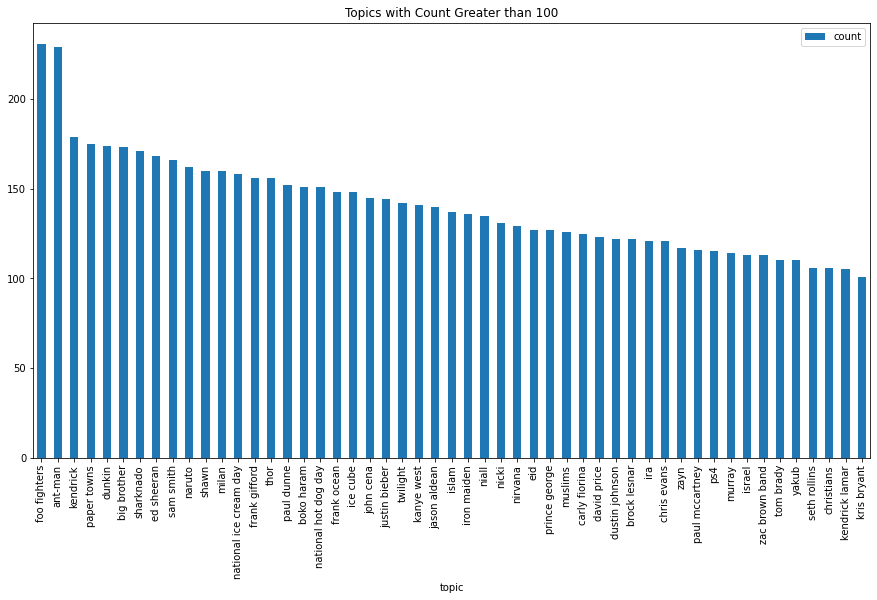

In [7]:
topics = dataset['topic'].value_counts() # topics is a pandas series (not df)
#topics.plot(kind='bar',figsize=(15,8)) # see original count of topics

# Gather topics with count 100 and up
topics2=[]
for index, value in topics.items():
  if value>99:
    #print(f"Index : {index}, Value : {value}")
    temp = index,value
    topics2.append(temp)

topics2 = pd.DataFrame(topics2, columns =['topic', 'count']) # convert into df
topics2.plot(x="topic", y=["count"], kind="bar",figsize=(15,8))
plt.title("Topics with Count Greater than 100")
topics2.count()  # showing top topics

#topics = topics.to_dict()
#print(type(topics))
#print(len(topics))
set_topics=set(dataset['topic'])
print(len(set_topics))
print(set_topics)

In [8]:
#Encode sentiment labels negative=0,positive=1
sentiment_label=LabelEncoder()
dataset['sentiment'] = sentiment_label.fit_transform(dataset['sentiment'])



### Create Word Index and Embeddings


In [9]:


def build_word_index(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index # dictionary mapping each word to an integer
    
    return word_index
  

word_to_int= build_word_index(dataset.tweet) # dictionary for tweets
word_to_int2= build_word_index(dataset.topic) # dictionary for topics



    

In [10]:
def build_embeddings(word_dict):
    embeddings_dict = {}
    # Open the glove embeddings text file
    file = open('Datasets/glove.6B.300d.txt')
    for line in file:
        # Read in each line, split words add to a list
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector
    file.close()
    print('Found %s word vectors.' %len(embeddings_dict))
    
    vocab_size = len(word_dict) + 1
    # creating a matrix with zeroes of shape vocab x embedding dimension
    embedding_matrix = np.zeros((vocab_size, 300)) #each embedding vector is of length 300
    # Iterate through word, index in the dictionary
    for word, i in word_dict.items():
       # use word from word_dict to search for its corresponding vector in embeddings
        embedding_vector = embeddings_dict.get(word) 
        if embedding_vector is not None and len(embedding_vector)==300:
            # Storing it in a matrix
            embedding_matrix[i] = embedding_vector 
    return embedding_matrix,embeddings_dict,vocab_size

embeddings,embeddings_dict,vocab_size = build_embeddings(word_to_int)
embeddings2,embeddings2_dict,vocab_size2 = build_embeddings(word_to_int2) # embeddings for topics


#Check that mappings look right
#int_friday = word_to_int['friday']
#Verify that the vectors for integer 7 are equal to those for 'Friday'
#if list(embeddings[int_friday]) == list(embeddings_dict['friday']):
#    print('True')
#print('embedding_matrix for integer which corresponds to "friday"',embeddings[int_friday])
#print('embedding_dict vector for "friday"',embeddings_dict['friday'])







Found 344175 word vectors.
Found 346186 word vectors.


In [11]:
#build word dictionary based on word_index and 
#pass them into the padded sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset.tweet)
word_index = tokenizer.word_index

# Same procedure for topics
#build word dictionary based on word_index and 
#pass them into the padded sequences
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(dataset.topic)
word_index2 = tokenizer2.word_index

#print(word_index)
#print(word_to_int)

### **Split Data into features and target data**

In [12]:
# Splitting the data into training and testing sets
dataset = shuffle(dataset)

# Split dataset 
X_a = dataset.tweet # feature a
X_b = dataset.topic # feature b
y = dataset.sentiment # target


# New split statements
X_a_train, X_a_test, X_b_train, X_b_test, y_train, y_test = train_test_split(X_a, X_b, y, test_size=0.2, random_state=1)
X_a_train, X_a_val, X_b_train, X_b_val, y_train, y_val = train_test_split(X_a_train, X_b_train, y_train, test_size=0.25, random_state=1)



# Create placeholders for padded sequences of chosen length 
X_a_train = pad_sequences(tokenizer.texts_to_sequences(X_a_train),maxlen = 60)
X_a_val = pad_sequences(tokenizer.texts_to_sequences(X_a_val),maxlen = 60)
X_a_test = pad_sequences(tokenizer.texts_to_sequences(X_a_test),maxlen = 60)

X_b_train = pad_sequences(tokenizer.texts_to_sequences(X_b_train),maxlen = 60)
X_b_val = pad_sequences(tokenizer.texts_to_sequences(X_b_val),maxlen = 60)
X_b_test = pad_sequences(tokenizer.texts_to_sequences(X_b_test),maxlen = 60)



# convert target data into arrays
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# reshape from 1D to 2D
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#General check for datatypes and shapes
print("y_train type",type(y_train))
print("y_val type",type(y_val))
print("X_a_train type",type(X_a_train))
print("X_a_train type",type(X_a_train))
print("X_b_train type",type(X_b_train))

print('X_a_train shape',X_a_train.shape)
print('X_a_val shape',X_a_val.shape)
print('X_a_test shape',X_a_test.shape)

print('X_b_train shape',X_b_train.shape)
print('X_b_val shape',X_b_val.shape)
print('X_b_test shape',X_b_test.shape)

print('y_train shape',y_train.shape)
print('y_val shape',y_val.shape)
print('y_test shape',y_test.shape)




y_train type <class 'numpy.ndarray'>
y_val type <class 'numpy.ndarray'>
X_a_train type <class 'numpy.ndarray'>
X_a_train type <class 'numpy.ndarray'>
X_b_train type <class 'numpy.ndarray'>
X_a_train shape (6330, 60)
X_a_val shape (2110, 60)
X_a_test shape (2111, 60)
X_b_train shape (6330, 60)
X_b_val shape (2110, 60)
X_b_test shape (2111, 60)
y_train shape (6330, 1)
y_val shape (2110, 1)
y_test shape (2111, 1)


In [13]:
#Define the Bidirectional LSTM Model
# Input layer 
embedding_layer = layers.Embedding(vocab_size,300,weights=[embeddings], input_length = 60)

input_a = Input(shape=(60,), dtype='int32')
input_b = Input(shape=(1,), dtype='int32')

# Pass inputs to the embedding layer
embedding_sequences = embedding_layer(input_a)
# dropout and conv layers 
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
# LSTM layer
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(1024, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
# Activation layer for final output
outputs = Dense(2, activation='softmax')(x)  
model = Model([input_a, input_b], outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 300)      3880500     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 60, 300)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 conv1d (Conv1D)                (None, 56, 64)       96064       ['spatial_dropout1d[0][0]']  

In [14]:
#previous loss function was binary_crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)


### **Train the Model**

In [15]:
class_weight = {0:3,1: 1.}
model.fit([X_a_train,X_b_train], y_train, batch_size=50, epochs=20,
          class_weight=class_weight,
          validation_data=([X_a_val,X_b_val], y_val), callbacks=[ReduceLROnPlateau])

Epoch 1/20
127/127 [==============================] - 64s 454ms/step - loss: 0.8521 - accuracy: 0.7821 - val_loss: 0.4521 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 2/20
127/127 [==============================] - 57s 445ms/step - loss: 0.6440 - accuracy: 0.8180 - val_loss: 0.4013 - val_accuracy: 0.8246 - lr: 1.0000e-04
Epoch 3/20
127/127 [==============================] - 58s 454ms/step - loss: 0.5751 - accuracy: 0.8376 - val_loss: 0.3477 - val_accuracy: 0.8536 - lr: 1.0000e-04
Epoch 4/20
127/127 [==============================] - 57s 444ms/step - loss: 0.5283 - accuracy: 0.8559 - val_loss: 0.3984 - val_accuracy: 0.8299 - lr: 1.0000e-04
Epoch 5/20
127/127 [==============================] - 57s 452ms/step - loss: 0.4701 - accuracy: 0.8690 - val_loss: 0.3413 - val_accuracy: 0.8521 - lr: 1.0000e-04
Epoch 6/20
127/127 [==============================] - 57s 447ms/step - loss: 0.4318 - accuracy: 0.8836 - val_loss: 0.3674 - val_accuracy: 0.8427 - lr: 1.0000e-04
Epoch 7/20
127/127 [========

In [16]:
print("Evaluate on test data")
results = model.evaluate([X_a_test,X_b_test], y_test, batch_size=10)
print("test loss, test acc:", results)


Evaluate on test data
212/212 [==============================] - 6s 29ms/step - loss: 0.4532 - accuracy: 0.8655
test loss, test acc: [0.45322176814079285, 0.8654665946960449]


              precision    recall  f1-score   support

    negative       0.67      0.73      0.70       447
    positive       0.93      0.90      0.91      1664

    accuracy                           0.87      2111
   macro avg       0.80      0.82      0.81      2111
weighted avg       0.87      0.87      0.87      2111



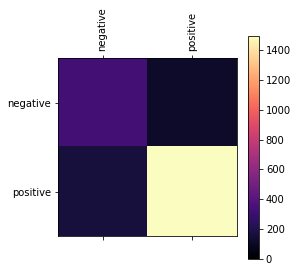

In [17]:


labels = {'negative':0,'positive':1}


# Add test vector "X_a_test" with corresponding "y_test" to trained model "model"
y_predicted = tensorflow.argmax(model.predict([X_a_test,X_b_test]), axis=1)

# Confusion matrix
cf = tensorflow.math.confusion_matrix(y_test, y_predicted)
plt.matshow(cf, cmap='magma')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels=labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels=labels)
plt.clim(0, None)

# Report
print(classification_report(y_test, y_predicted, target_names=labels))